# Статистический анализ данных сервиса аренды самокатов

В работе необходимо проанализировать данные сервиса аренды самокатов GoFast. У нас в распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
* без подписки
   * абонентская плата отсутствует;
   * стоимость одной минуты поездки — 8 рублей;
   * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
   * абонентская плата — 199 рублей в месяц;
   * стоимость одной минуты поездки — 6 рублей;
   * стоимость старта — бесплатно.

## Загрузка данных

Импортируем необходимые для работы библиотеки:

In [76]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
import seaborn as sns

Загрузим данные из файлов

In [77]:
users = pd.read_csv('data/users_go.csv') #Данные о пользователях
rides = pd.read_csv('data/rides_go.csv') #Данные о поезках
subs =  pd.read_csv('data/subscriptions_go.csv') #Данные о подписках

Изучим общую информацио о загруженных данных

Изучим информацию о пользователях

In [78]:
users.head(5) #Выведем первые 5 строк датафрейма с пользователями

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Как можно заметить данные по пользователям содержат:
* ID пользователя;
* Имя пользователя;
* Возраст пользоваетеля;
* Город, в котором пользователь живет;
* Тип подписки.

In [79]:
users.info() #Рассмотрим общую информацию по датафрейму

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Данные содержат 1565 строк. В каждом столбце все значения заполнены.

Изучим информацию о поездках

In [80]:
rides.head() # Выведем первые строки датафрейма с поезками

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Как можно заметить данные по поездкам содержат:
* ID пользователя;
* Дистанцию поездки;
* Длительность поездки;
* Дата, в которую была совершена поездка.

In [81]:
rides.info() #Выведем общую информацию по датафрейму с поездками

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Таблица содержит 18068 строк. В каждом столбце все значения заполнены.

In [82]:
subs.head() # Выведем строки таблицы подписок

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Как можно заметить данные по подпискам содержат:

* Тип подписки;
* Стоимость минуты поездки;
* Стоимость старта поездки;
* Стоимость подписки.

## Предобработка данных

Приведем столбец `date` в таблице `rides` к типу данных datetime

In [83]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Создадим столбец с номером месяца в таблице `rides`

In [84]:
rides['month'] = pd.DatetimeIndex(rides['date']).month

**Проверка периода данных**

Узнаем за какой промежуток были собраны данные

In [85]:
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [86]:
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

Данные собирались в течении 2021 года. Поэтому значения в столбце `month` - месяцы 2021-го года.

Рассмотрим данные таблицы поездок после изменений

In [87]:
rides.head() # Выведем первые строки таблицы поездок

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


В ходе первичного ознакомления с данными было выявлено, что пропущенные значения отсутсвуют

Исследуем таблицы на дубликаты

In [88]:
print(f'Количество явных дубликатов в таблице с пользователями: {users.duplicated().sum()}')
print(f'Количество явных дубликатов в таблице с поездками: {rides.duplicated().sum()}')

Количество явных дубликатов в таблице с пользователями: 31
Количество явных дубликатов в таблице с поездками: 0


Удалим дубликаты из таблицы с пользователями

In [89]:
users = users.drop_duplicates().reset_index(drop=True)

Убедимся в отсутствии дубликатов

In [90]:
users.duplicated().sum()

0

В ходе предобработки данных были удалены дубликаты из таблицы с пользователями

In [91]:
# Комментарий ревьюера
temp = rides.copy() # Создаем копию, что бы не изменять текущий датасет
display(temp['distance'].head(3))
# Округление расстояния
temp['distance'] = temp['distance'].round(2)
temp['distance'].head(3)

0    4409.919140
1    2617.592153
2     754.159807
Name: distance, dtype: float64

0    4409.92
1    2617.59
2     754.16
Name: distance, dtype: float64

**Проведём проверку пропусков во всех таблицах.**

Количество пропусков в столбцах датасета `users`

In [92]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Количество пропусков в столбцах датасета `rides`

In [93]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Количество пропусков в столбцах датасета `subs`

In [94]:
subs.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Во всех датасетах отсутсвуют пропуски

Проверим на аномалии столбец с длительностью поездок 

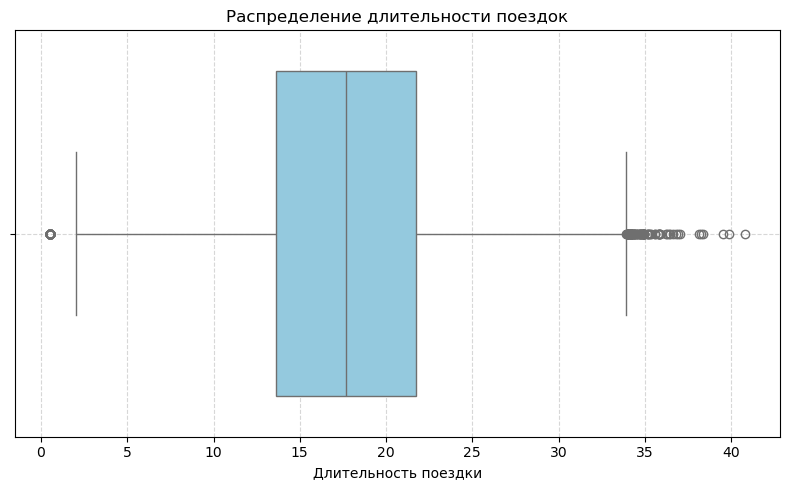

In [95]:
plt.figure(figsize=(8, 5))  # задаём размер графика
sns.boxplot(x='duration', data=rides, color='skyblue')  # аккуратный boxplot

plt.xlabel('Длительность поездки')   # подпись оси X
plt.title('Распределение длительности поездок')  # заголовок

plt.grid(True, linestyle='--', alpha=0.5)  # сетка для читаемости
plt.tight_layout()
plt.show()

В столбце с длительностю поездок наблюдается несколько выбросов сверху и снизу.

**Округление данных**

Округлим данные в столбце с длительностью поездки до двух знаков после точки

In [96]:
display(rides['distance'].head(3))
# Округление расстояния
rides['distance'] = rides['distance'].round(2)
rides['distance'].head(3)

0    4409.919140
1    2617.592153
2     754.159807
Name: distance, dtype: float64

0    4409.92
1    2617.59
2     754.16
Name: distance, dtype: float64

## Исследовательский анализ данных

### Исследование частоты встречаемости городов

Исследум данные о количестве пользователей из различных городов.
Построим столбчатую диаграмму.

In [97]:
ax = users['city'].value_counts(ascending=True).plot.bar(color='green',rot = 50,xlabel='Город', ylabel='Количество',grid=True)
ax.set_title('Количество пользователей из определённого города')

Text(0.5, 1.0, 'Количество пользователей из определённого города')

**Вывод:**

В исследуемых данных представлены пользователи из восьми городов. Большинство пользователей из Пятигорска. Наименьшее количество пользователей из Москвы.

**Выведем числовые зачения частотности городов**

In [98]:
users['city'].value_counts(ascending=False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

### Исследование количества пользователей с подпиской

Исследуем соотношение пользователей с оформленной подпиской и без неё.

На основании столбца с данными о подписке, в таблице с пользователями, построим столбчатую диаграмму.

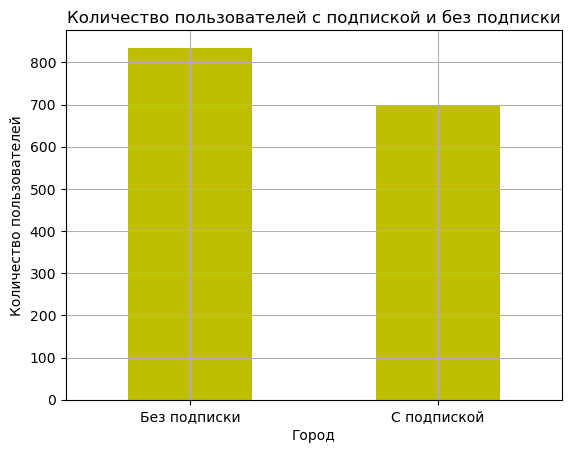

In [99]:
df = users['subscription_type'].value_counts()
df.index = ['Без подписки','С подпиской']
ax = df.plot.bar(rot=0,color='y',grid=True)
ax.set_title('Количество пользователей с подпиской и без подписки')
ax.set_ylabel('Количество пользователей')
plt.show()

Найдём процент пользователей с подпиской от общего количества 

In [100]:
round(df['С подпиской'] / (df['С подпиской'] + df['Без подписки']) * 100,2)

45.57

Найдём процент пользователей без подпискт от общего количества 

In [101]:
round(df['Без подписки'] / (df['С подпиской'] + df['Без подписки']) * 100,2)

54.43

**Вывод:**

В исследуемых данных количество пользователей с подпиской составляет 46.6 %, количество пользователей без подписки - 54.4 %.

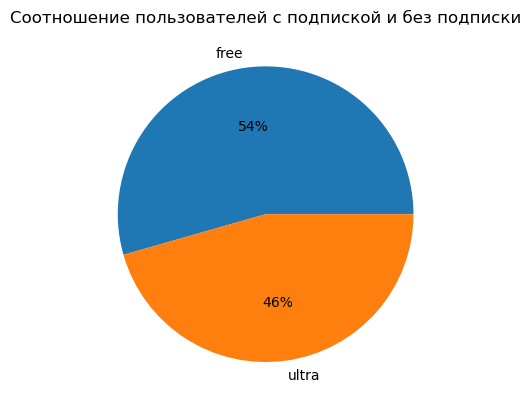

In [102]:
# Комментарий ревьюера
import matplotlib.pyplot as plt
temp = users.copy()
temp['subscription_type'].value_counts().plot(
    kind= 'pie',
    title= 'Соотношение пользователей с подпиской и без подписки',
    autopct = "%.0f%%",
    ylabel= ""
)
plt.show()

### Исследование возраста пользователей 

Найдём максимальный и минимальный возраст в данных

In [103]:
mi = users['age'].min()
ma = users['age'].max()
print(f'Минимальный возраст пользователя: {mi}')
print(f'Максимальный возраст пользователя: {ma}')

Минимальный возраст пользователя: 12
Максимальный возраст пользователя: 43


**Рассмотрим сводную статистику методом describe()**

In [104]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Построим столчатую диаграмму для возраста пользователей и их количества в данных. 

**Построим гистрограмму**

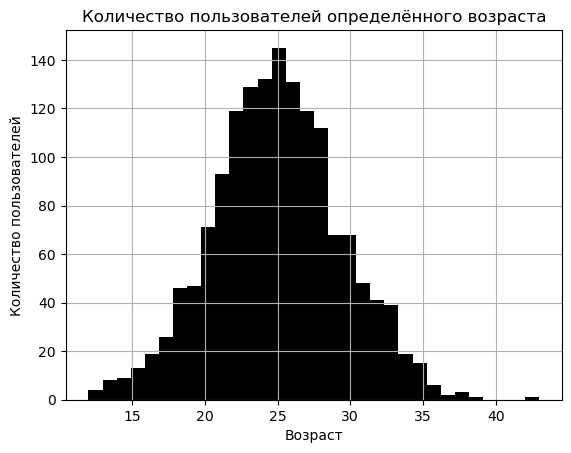

In [105]:
ax = users['age'].hist(bins=32,color='k',grid = True)
ax.set_title('Количество пользователей определённого возраста')
ax.set_xlabel('Возраст')
ax.set_ylabel('Количество пользователей')
plt.show()

Распределение пользователей по возрасту похоже на нормальное.

**Вывод:**

В исследуемых данных представлены пользователи от 12 до 43 лет. Наибольшее количество пользователей имеют возраст 24-26 лет.
Меньше всего пользователей с возрастом больше 37 лет.

**Новый вывод:**

Наибольшее количество пользователей имеют возраст 24-26 лет. Меньше всего пользователей с возрастом больше 35 лет и меньше 15.
Следует отметить, что среди пользователей некоторым менее 18 лет, именно с этого возраста разрешен прокат самокатов. В некоторых компаниях и регионах разрешено с 14 лет, но при письменном согласии родителей. В датасете минимальный возраст 12 лет, это явное нарушение существующих норм.

### Исследование расстояния, которое пользователь преодолел за одну поездку

Рассмострим описательную статистику по столбцу с расстояниями поездок

In [106]:
rides['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

Построим гистограмму по столбцу с расстояниями

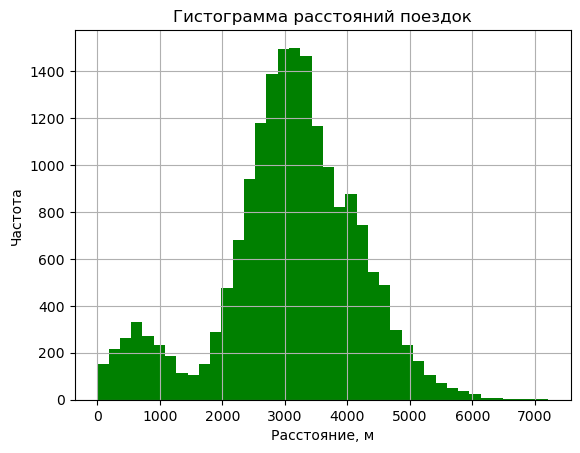

In [107]:
ax = rides['distance'].plot.hist(bins=40,grid=True,color='g')
ax.set_xlabel('Расстояние, м')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма расстояний поездок')
plt.show()

**Вывод:**

Среднее расстояние, которое проезжают пользователи на самокате - 3,1 км. На расстояниях 600 м. и 3000 м. наблюдаются локальные максимумы

### Исследование продолжительности поездок

Рассмострим описательную статистику по столбцу с продолжительностями поездок 

In [108]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Построим гистограмму по столбцу с длительностями поездок

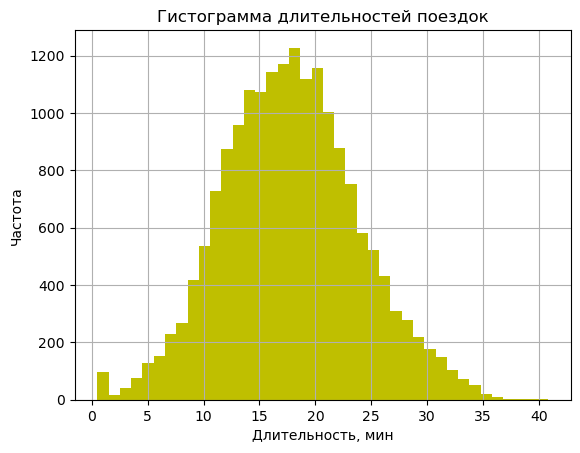

In [109]:
ax = rides['duration'].plot.hist(bins=40,grid=True,color='y')
ax.set_xlabel('Длительность, мин')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма длительностей поездок')
plt.show()

**Вывод:**

Средняя длительность поездок  пользователей - 17 мин. В данных наблюдается аномалия при длительностях поездки меньше минуты.

**Общий вывод по разделу:**

1. В исследуемых данных представлены пользователи из восьми городов. Большинство пользователей из Пятигорска. Наименьшее количество пользователей из Москвы.
2. В исследуемых данных количество пользователей с подпиской составляет 46.6 %, количество пользователей без подписки - 54.4 %.
3. Наибольшее количество пользователей имеют возраст 24-26 лет. Меньше всего пользователей с возрастом больше 35 лет и меньше 15. Следует отметить, что в датасете минимальный возраст 12 лет, это явное нарушение существующих норм проката самокатов.
4. Среднее расстояние, которое проезжают пользователи на самокате - 3,1 км. На расстояниях 600 м. и 3000 м. наблюдаются локальные максимумы
5. Средняя длительность поездок пользователей - 17 мин. В данных наблюдается аномалия при длительностях поездки меньше минуты.




## Объединение данных

Объединим данные в один датафрейм

In [110]:
df = rides.merge(users,on='user_id') #Объединим таблицу поездок с таблицей пользоватлей по столбцу 'user_id'
df = df.merge(subs,on='subscription_type') # Объединим получившуюся таблицу с таблицей подписок по столбцу с типом подписки
df.head() #Выведем первые строки получившегося датафрейма

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


**Размерность и проверка на пропуски**

Выведем разменость датасета

In [111]:
print(f'В объединённом датасете {df.shape[0]} строк и {df.shape[1]} столбцов')

В объединённом датасете 18068 строк и 12 столбцов


Проверим датасет на пропуски

In [112]:
df.isna().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

В датасете отсутствуют пропуски

Создадим датафреймы с поезками, которые совершили пользователи без подписки

In [113]:
df_free = df.query('subscription_type == "free"').reset_index(drop=True)

In [114]:
df_free.head() # Выведем первые строки датафрейма

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.69,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,846.93,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,4004.43,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,1205.91,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,3047.38,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


Создадим датафреймы с поездками, которые совершили пользователи с подпиской

In [115]:
df_ultra = df.query('subscription_type == "ultra"').reset_index(drop=True)

In [116]:
df_ultra.head() # Выведем первые строки датафрейма

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


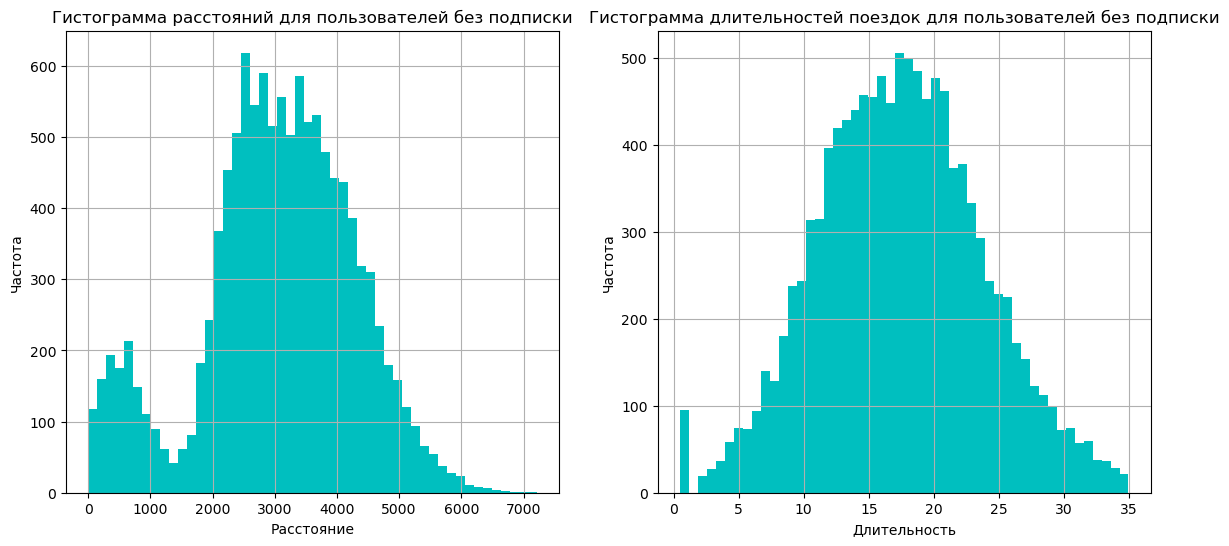

In [117]:
fig, axes = plt.subplots(1,2)

fig.set_size_inches(14, 6)
plt.subplot(1, 2, 1)
axes = df_free['distance'].plot.hist(bins=50, grid=True, color ='c')
axes.set_xlabel('Расстояние')
axes.set_ylabel('Частота')
axes.set_title('Гистограмма расстояний для пользователей без подписки')

plt.subplot(1, 2, 2)
axes = df_free['duration'].plot.hist(bins=50, grid=True, color ='c')
axes.set_xlabel('Длительность')
axes.set_ylabel('Частота')
axes.set_title('Гистограмма длительностей поездок для пользователей без подписки')

plt.show()

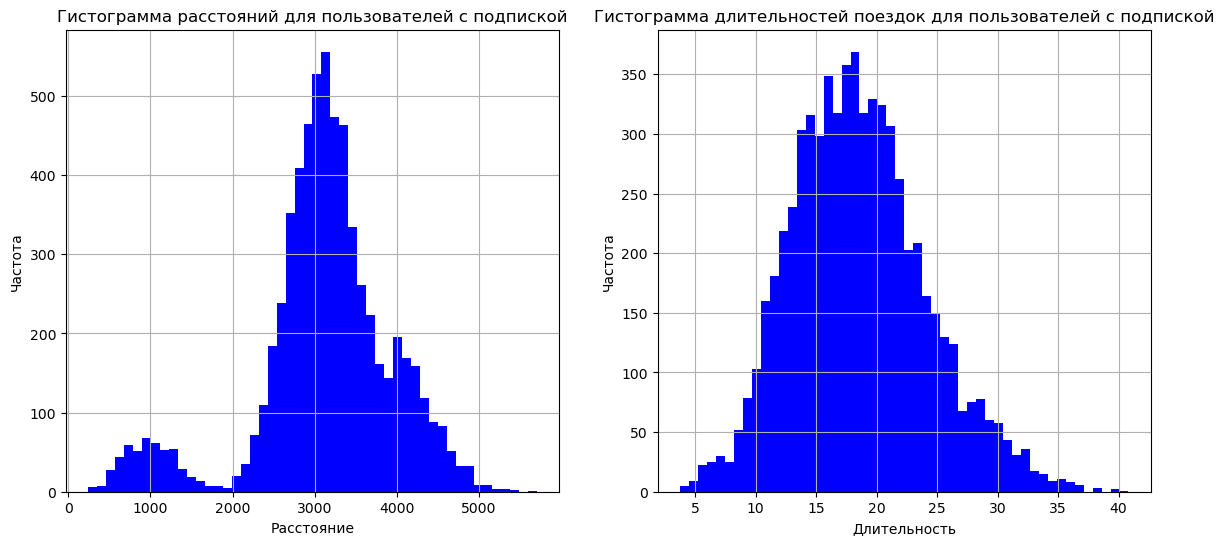

In [118]:
fig, axes = plt.subplots(1,2)

fig.set_size_inches(14, 6)
plt.subplot(1, 2, 1)
axes = df_ultra['distance'].plot.hist(bins=50, grid=True, color ='b')
axes.set_xlabel('Расстояние')
axes.set_ylabel('Частота')
axes.set_title('Гистограмма расстояний для пользователей с подпиской')

plt.subplot(1, 2, 2)
axes = df_ultra['duration'].plot.hist(bins=50, grid=True, color ='b')
axes.set_xlabel('Длительность')
axes.set_ylabel('Частота')
axes.set_title('Гистограмма длительностей поездок для пользователей с подпиской')

plt.show()

Построенные графики показывают различия в мере изменчивости переменной.
Вычислим стандартные отклонения переменных

In [119]:
print(f'Стандартное отклонение для расстояний у пользователей без подписки: {df_free["distance"].std()}')
print(f'Стандартное отклонение для расстояний у пользователей с подпиской: {df_ultra["distance"].std()}')
print()
print(f'Стандартное отклонение для длительности у пользователей без подписки: {df_free["duration"].std()}')
print(f'Стандартное отклонение для длительности у пользователей c подпиской: {df_ultra["duration"].std()}')

Стандартное отклонение для расстояний у пользователей без подписки: 1246.173809519415
Стандартное отклонение для расстояний у пользователей с подпиской: 836.895368921258

Стандартное отклонение для длительности у пользователей без подписки: 6.326802859586479
Стандартное отклонение для длительности у пользователей c подпиской: 5.572048329261361


**Дополним анализ описательной статистикой**

In [120]:
df_free.describe()

,user_id,distance,duration,date,month,age,minute_price,start_ride_price,subscription_fee
count,11568.000000,11568.000000,11568.000000,11568,11568.000000,11568.000000,11568.0,11568.0,11568.0
mean,1120.527230,3045.495284,17.390909,2021-07-01 21:47:03.236514560,6.522994,24.893326,8.0,50.0,0.0
min,700.000000,0.860000,0.500000,2021-01-01 00:00:00,1.000000,12.000000,8.0,50.0,0.0
25%,915.000000,2366.560000,12.958437,2021-04-02 00:00:00,4.000000,22.000000,8.0,50.0,0.0
50%,1123.000000,3114.650000,17.326890,2021-07-01 00:00:00,7.000000,25.000000,8.0,50.0,0.0
75%,1328.000000,3905.695000,21.594071,2021-09-30 00:00:00,9.000000,28.000000,8.0,50.0,0.0
max,1534.000000,7211.010000,34.948498,2021-12-30 00:00:00,12.000000,43.000000,8.0,50.0,0.0
std,241.165628,1246.173810,6.326803,NaN,3.449770,4.481100,0.0,0.0,0.0


In [121]:
df_ultra.describe()

,user_id,distance,duration,date,month,age,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500,6500.000000,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,3115.445431,18.541985,2021-06-28 21:31:34.153846016,6.422308,24.892615,6.0,0.0,199.0
min,1.000000,244.210000,3.760353,2021-01-01 00:00:00,1.000000,12.000000,6.0,0.0,199.0
25%,175.000000,2785.447500,14.524654,2021-04-01 00:00:00,4.000000,22.000000,6.0,0.0,199.0
50%,351.000000,3148.640000,18.178153,2021-06-27 00:00:00,6.000000,25.000000,6.0,0.0,199.0
75%,525.000000,3560.577500,21.884129,2021-09-25 00:00:00,9.000000,28.000000,6.0,0.0,199.0
max,699.000000,5699.770000,40.823963,2021-12-30 00:00:00,12.000000,38.000000,6.0,0.0,199.0
std,201.099339,836.895369,5.572048,NaN,3.414616,4.757208,0.0,0.0,0.0


**Вывод:**

Распределения длительности и расстояния поездок для пользователей без подписки характеризуется большим стандартным отклонением, по сравнению с распределениями для пользователей с подпиской.

##  Подсчёт выручки

Создадим сводную таблицу, в которой будет информация о суммарном расстоянии, количестве поездок и суммарном времени для каждого пользователя за каждый месяц.

**Округление**

Перед тем как создавать сводную таблицу округлим данные по длительности поездки до минут.

In [122]:
df['duration'] = np.ceil(df['duration']) 

In [123]:
df_agg = df.pivot_table(index=['user_id','month'],values=['distance','duration'],aggfunc='sum')
df_agg['count'] = df.pivot_table(index=['user_id','month'],values='distance',aggfunc='count')
df_agg.head(10) 

distance  duration  count
user_id month                           
1       1       7027.51      42.0      2
        4        754.16       7.0      1
        8       6723.47      46.0      2
        10      5809.91      32.0      2
        11      7003.50      56.0      3
        12      6751.63      28.0      2
2       3      10187.73      63.0      3
        4       6164.39      40.0      2
        6       3255.34      14.0      1
        7       6780.73      48.0      2

Для подсчёта общей стоимости создадим таблицу `df_agg_calc` на основании `df_agg` содержащаю стоимость одной минуты поезки, стоимость старта поездки и стоимость подписки

In [124]:
df_agg_calc = df_agg.join(df.pivot_table(index=['user_id','month'],
                                         values=['minute_price','start_ride_price','subscription_fee'],aggfunc='mean'))
df_agg_calc.head(10)

distance  duration  count  minute_price  start_ride_price  \
user_id month                                                              
1       1       7027.51      42.0      2           6.0               0.0   
        4        754.16       7.0      1           6.0               0.0   
        8       6723.47      46.0      2           6.0               0.0   
        10      5809.91      32.0      2           6.0               0.0   
        11      7003.50      56.0      3           6.0               0.0   
        12      6751.63      28.0      2           6.0               0.0   
2       3      10187.73      63.0      3           6.0               0.0   
        4       6164.39      40.0      2           6.0               0.0   
        6       3255.34      14.0      1           6.0               0.0   
        7       6780.73      48.0      2           6.0               0.0   

               subscription_fee  
user_id month                    
1       1                 199.0  
        4                 199.0  
        8                 199.0  
        10                199.0  
        11                199.0  
        12                199.0  
2       3                 199.0  
        4                 199.0  
        6                 199.0  
        7                 199.0

**Проверим пропуски в столбцах  созданной таблицы перед расчётом**

In [125]:
df_agg_calc.isna().sum()

distance            0
duration            0
count               0
minute_price        0
start_ride_price    0
subscription_fee    0
dtype: int64

В таблице отсутсвуют пропуски.

In [126]:
def calc(line):
    return line['count']*line['start_ride_price'] + line['minute_price']*line['duration'] + line['subscription_fee']

Применим написанную функцию к датафрейму и добавим полученный в ходе расчётов столбец в исходный датафрейм `df_agg`

In [127]:
df_agg['revenue'] = df_agg_calc.apply(calc, axis=1)
df_agg_calc['revenue'] = df_agg_calc.apply(calc, axis=1)
df_agg.head()

distance  duration  count  revenue
user_id month                                    
1       1       7027.51      42.0      2    451.0
        4        754.16       7.0      1    241.0
        8       6723.47      46.0      2    475.0
        10      5809.91      32.0      2    391.0
        11      7003.50      56.0      3    535.0

В ходе данного этапа были получены данные с помесячной выручкой для каждого пользователя

## Проверка гипотез

### Проверка гипотезы о равенстве длительности поездки для подписчиков и пользователей без подписки

Для того, чтобы проверить равенство длительностей поездок в выборках с подпиской и без необходимо проверить гипотезу о равенстве средних двух генеральных совокупностей.

Для этого применяется Т-тест для несвязанных выборок.

* Нулевая гипотеза - средние генеральных совокупностей равны
* Альтернативная гипотеза - среднее генеральной совокупности длительности поездок для пользователей без подписки меньше среднего генеральной совокупности длительности поездок для пользователей с подпиской

In [128]:
alpha = 0.01
result = st.ttest_ind(df_ultra['duration'],df_free['duration'], alternative='greater') 
#Проводя тест будем считать что дисперсии равны (можно дополнительно провести F-тест, но мы это делать не будем) 
print(f"Полученное p-значение: {result.pvalue}")
if alpha < result.pvalue:
    print(f'p-значение больше уровня значимости')
else:
    print(f"p-значение меньше уровня значимости")

Полученное p-значение: 1.2804098316645618e-34
p-значение меньше уровня значимости


p-значение меньше уровня значимости - нулевая гипотеза отвергается и принимается альтернативная гипотеза

**Покажем средние выборок**

In [129]:
print(f'Средняя длительность поездок у пользоватлей с подпиской равна: {df_ultra["duration"].mean()}')
print(f'Средняя длительность поездок у пользоватлей без подписки равна: {df_free["duration"].mean()}')

Средняя длительность поездок у пользоватлей с подпиской равна: 18.54198516280583
Средняя длительность поездок у пользоватлей без подписки равна: 17.39090929866399


**Вывод** 

Статистически доказано, что люди с подпиской в среднем имеют б**о**льшую длительность поездки по сравнению с людьми без подписки

### Проверка гипотезы о равенстве расстояния поездки для подписчиков

Для того, чтобы проверить равенство среднего поездок в выборках с подпиской и заданного числа необходимо проверить гипотезу о равенстве среднего генеральных совокупности заданному числу.

Для этого применяется Т-тест для одной выборки.

* Нулевая гипотеза - средняя длительность поездки для пользователей с подпиской равна 3130 м.
* Альтернативная гипотеза - средняя длительность поездки для пользователей с подпиской больше чем 3130 м.

In [130]:
alpha = 0.01

distance = 3130
result = st.ttest_1samp(df_ultra['distance'], distance, alternative='greater') 

print(f"Полученное p-значение: {result.pvalue}")
if alpha < result.pvalue:
    print(f'p-значение больше уровня значимости')
else:
    print(f"p-значение меньше уровня значимости")

Полученное p-значение: 0.9195362605842414
p-значение больше уровня значимости


p-значение больше уровня значимости - нулевая гипотеза не отвергается.

**Вывод**

Статистически доказано, что среднее значение пройденных расстояний у пользователей с подпиской не превышает расстояния оптимального по износу самокатов.

### Проверка гипотезы о равенстве выручек

Найдём выручку по месяцам для пользователей с подпиской и без.

Воспользуемся таблицей из пункта 5 для того, чтобы отделить людей с подпиской и без.

У людей с подпиской цена минуты равна 6 рублям

In [131]:
df_ultra = df_agg_calc.query("minute_price == 6")
df_ultra.head(5)

distance  duration  count  minute_price  start_ride_price  \
user_id month                                                              
1       1       7027.51      42.0      2           6.0               0.0   
        4        754.16       7.0      1           6.0               0.0   
        8       6723.47      46.0      2           6.0               0.0   
        10      5809.91      32.0      2           6.0               0.0   
        11      7003.50      56.0      3           6.0               0.0   

               subscription_fee  revenue  
user_id month                             
1       1                 199.0    451.0  
        4                 199.0    241.0  
        8                 199.0    475.0  
        10                199.0    391.0  
        11                199.0    535.0

У людей без подписки стоимость минуты поездки равна 8-ми рублям

In [132]:
df_free = df_agg_calc.query("minute_price == 8")
df_free.head(5)

distance  duration  count  minute_price  start_ride_price  \
user_id month                                                              
700     1       2515.69      15.0      1           8.0              50.0   
        2      13446.65      89.0      5           8.0              50.0   
        3       3798.33      19.0      1           8.0              50.0   
        4       2984.55      16.0      1           8.0              50.0   
        6       5927.65      29.0      2           8.0              50.0   

               subscription_fee  revenue  
user_id month                             
700     1                   0.0    170.0  
        2                   0.0    962.0  
        3                   0.0    202.0  
        4                   0.0    178.0  
        6                   0.0    332.0

Найдём суммарную выручку по месяцам по найденным выборкам

In [133]:
df_free = df_free.pivot_table(index = 'month',values='revenue',aggfunc='sum')
df_free.head(2)

,revenue
month,
1,193850.0
2,165856.0


In [134]:
df_ultra = df_ultra.pivot_table(index = 'month',values='revenue',aggfunc='sum')
df_ultra.head(2)

,revenue
month,
1,144108.0
2,124572.0


Построим графики

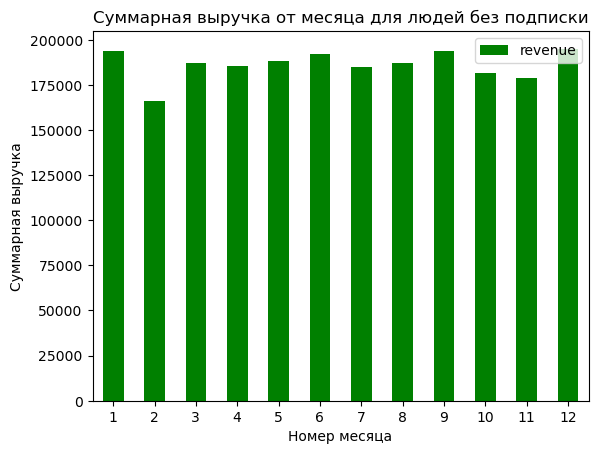

In [135]:
ax = df_free.pivot_table(index = 'month',values='revenue',aggfunc='sum').plot.bar(rot=0, color='g')
ax.set_xlabel('Номер месяца')
ax.set_ylabel('Суммарная выручка')
ax.set_title('Суммарная выручка от месяца для людей без подписки')
plt.show()

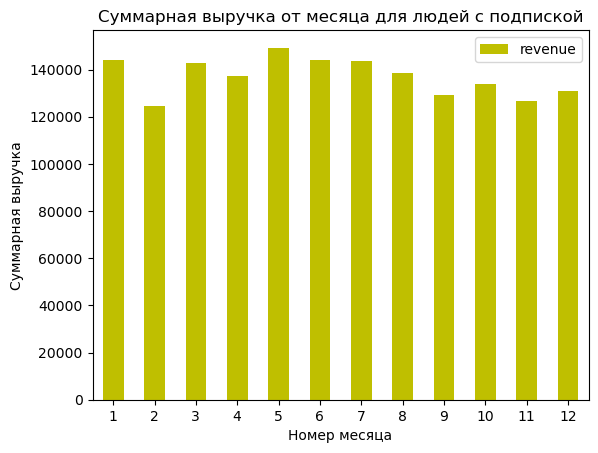

In [136]:
ax = df_ultra.pivot_table(index = 'month',values='revenue',aggfunc='sum').plot.bar(rot=0, color='y')
ax.set_xlabel('Номер месяца')
ax.set_ylabel('Суммарная выручка')
ax.set_title('Суммарная выручка от месяца для людей c подпиской')
plt.show()

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Для этого воспользуемся Т-тестом для несвязанных выборок

* Нулевая гипотеза - средние генеральных совокупностей равны
* Альтернативная гипотеза - среднее генеральной совокупности суммарной выручки для пользователей с подпиской **больше** среднего генеральной совокупности суммарной выручки для пользователей без подписки

In [137]:
alpha = 0.01
result = st.ttest_ind(df_ultra,df_free, alternative='greater') 

print(f"Полученное p-значение: {result.pvalue}")
if alpha < result.pvalue:
    print(f'p-значение больше уровня значимости')
else:
    print(f"p-значение меньше уровня значимости")

Полученное p-значение: [1.]
p-значение больше уровня значимости


p-значение больше уровня значимости, поэтому у нас недостаточно оснований для отклонения нулевой гипотезы. 

Теперь проведём другой тест для того чтобы ответить на вопрос: меньше ли средняя выручка у пользователей с подпиской или нет.

* Нулевая гипотеза - средние генеральных совокупностей равны
* Альтернативная гипотеза - среднее генеральной совокупности суммарной выручки для пользователей с подпиской **меньше** среднего генеральной совокупности суммарной выручки для пользователей без подписки

In [138]:
alpha = 0.01
result = st.ttest_ind(df_ultra,df_free, alternative='less') 

print(f"Полученное p-значение: {result.pvalue}")
if alpha < result.pvalue:
    print(f'p-значение больше уровня значимости')
else:
    print(f"p-значение меньше уровня значимости")

Полученное p-значение: [2.39814174e-13]
p-значение меньше уровня значимости


p-значение меньше уровня значимости, поэтому у нас достаточно оснований для отклонения нулевой гипотезы и принятия альтернативной.

**Вывод**:

Статистически доказано, что средняя суммарная выручка по месяцам для пользователей с подпиской меньше, чем у пользователей без неё

## Общий вывод

При исследовании были получены следующие результаты:

1. Первичный анализ данных:

   * Были проанализарованны датасеты с данными пользователей, данными о поездках и данными о подписке. Данные о поездках были собраны в течении 2021-го года.


2. Предобработка данных:
   
   * Было проведено исследование пропущенных значений и дубликатов в датасетах. Пропущенных значений не оказалось. Были удалены дубликаты.


3. Исследовательский анализ данных:
    
   * Большинство пользователей из Пятигорска. Наименьшее количество        пользователей из Москвы;
   
   * Количество пользователей с подпиской составляет 46.6 %, количество пользователей без подписки - 54.4 %;
   
   * Наибольшее количество пользователей имеют возраст 24-26 лет. Меньше всего пользователей с возрастом больше 35 лет и меньше 15. Следует отметить, что в датасете минимальный возраст 12 лет, это явное нарушение существующих норм проката самокатов.
   
   * Среднее расстояние, которое проезжают пользователи на самокате - 3,1 км;
   
   * Средняя длительность поездок пользователей - 17 мин.
     
      
4. Исследование параметров пользователей с подпиской и без подписки

   * Распределения длительности и расстояния поездок для пользователей без подписки характеризуется большим стандартным отклонением, по сравнению с распределениями для пользователей с подпиской.


5. Подсчёт выручки:

   * Была посчитанна помесячная выручка для каждого пользователя. (Необходимо для проверки гипотезы о выручке).


6. Статистический анализ данных:
    
   * Доказано, что люди с подпиской в среднем имеют б**о**льшую длительность поездки, по сравнению с людьми без подписки;
    
   * Доказано, что среднее пройденное расстояние у пользователей с подпиской не превышает значения расстояния оптимального по износу самокатов.
    
   * Доказано, что средняя суммарная выручка по месяцам для пользователей с подпиской меньше, чем у пользователей без неё.  
   